## GS Hackathon Project

### Summary

In our project we will be leveraging the Marquee API, along with several other external datasets to attempt to answer how weather may be impacting the spread of COVID-19 around the world.

### 1 - Getting Started

In [ ]:
pip install gs_quant

In [ ]:
from gs_quant.session import GsSession, Environment

We will start by creating dataframes for the three countries we will be analyzing. South Korea, South Africa, and Italy. 

In [ ]:
from gs_quant.data import Dataset
import pandas as pd 
import datetime

end = datetime.date(2020, 12, 7)
start = datetime.date(2020, 6, 1)

Italy_df = df = Dataset('COVID19_COUNTRY_DAILY_WHO').get_data(countryId='IT', start=start, end=end)
SouthKorea_df = Dataset('COVID19_COUNTRY_DAILY_WHO').get_data(countryId='KR', start=start, end=end)
SouthAfrica_df = Dataset('COVID19_COUNTRY_DAILY_WHO').get_data(countryId='ZA', start=start, end=end)


Next, we will create dataframes containing weather data for each country from the daily temperature dataset from NOAA. (https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/locations/FIPS:IT/detail)

In [ ]:
Italy_weather = pd.read_csv('Italy.csv').groupby('DATE').mean()
Italy_weather.set_index(pd.to_datetime(Italy_weather.index), inplace=True, drop=True)

SouthAfrica_weather = pd.read_csv('SouthAfrica.csv').groupby('DATE').mean()
SouthAfrica_weather.set_index(pd.to_datetime(SouthAfrica_weather.index), inplace=True, drop=True)

SouthKorea_weather = pd.read_csv('SouthKorea.csv').groupby('DATE').mean()
SouthKorea_weather.set_index(pd.to_datetime(SouthKorea_weather.index), inplace=True, drop=True)



# 2 - Analyzing the data

In [ ]:
import seaborn as sns
from matplotlib import pyplot
import numpy as np
from scipy.stats import pearsonr
from scipy.signal import argrelextrema
sns.set_style("dark")

months_recorded = ['JUN','JUL','AUG','SEPT','OCT','NOV','DEC']

First, we begin by analyzing the average temperature of the country compared against daily new cases.

In [ ]:
def compare_cases_to_temperature(cases, temperatures, label):
    cases = cases.loc[:, 'newConfirmed'].to_numpy()
    temperatures = temperatures.loc[:, 'TAVG'].to_numpy()
    months_recorded = ['JUN','JUL','AUG','SEPT','OCT','NOV','DEC']
    fig, axs = pyplot.subplots(3, 1, figsize=(8,10))
    c_max_index = argrelextrema(cases, np.greater, order=5)
    axs[0].plot(cases)
    axs[0].scatter(c_max_index[0],cases[c_max_index[0]],linewidth=0.3, s=50, c='r', label='Cases Spike Increase')
    axs[0].set_xticks([31 * x for x in range(7)])
    axs[0].set_xticklabels(months_recorded)
    axs[0].set(title='%s: Spike of New Cases' % label,xlabel='Month', ylabel='Daily New Cases')
    axs[0].legend()
        
    t_max_index = argrelextrema(temperatures, np.less, order=5)
    axs[1].plot(temperatures)
    axs[1].scatter(t_max_index[0],temperatures[t_max_index[0]],linewidth=0.3, s=50, c='g', label='Temperature Spike Decrease')
    axs[1].set_xticks([31 * x for x in range(7)])
    axs[1].set_xticklabels(months_recorded)
    axs[1].set(title='%s: Spike of Average Temperature' % label,xlabel='Month', ylabel='Average Temperature')
    axs[1].legend()
    
    axs[2].plot(cases)
    axs[2].scatter(c_max_index[0],cases[c_max_index[0]],linewidth=0.3, s=50, c='r', label='Cases Spike Increase')
    axs[2].scatter(t_max_index[0],cases[t_max_index[0]],linewidth=0.3, s=50, c='g', label='Temperature Spike Decrease')
    axs[2].set_xticks([31 * x for x in range(7)])
    axs[2].set_xticklabels(months_recorded)
    axs[2].set(title='%s: Spike of New Cases with Tempreture Spike indication' % label,xlabel='Month', ylabel='Average Temperature')
    axs[2].legend()
        
    pyplot.tight_layout(h_pad=3)

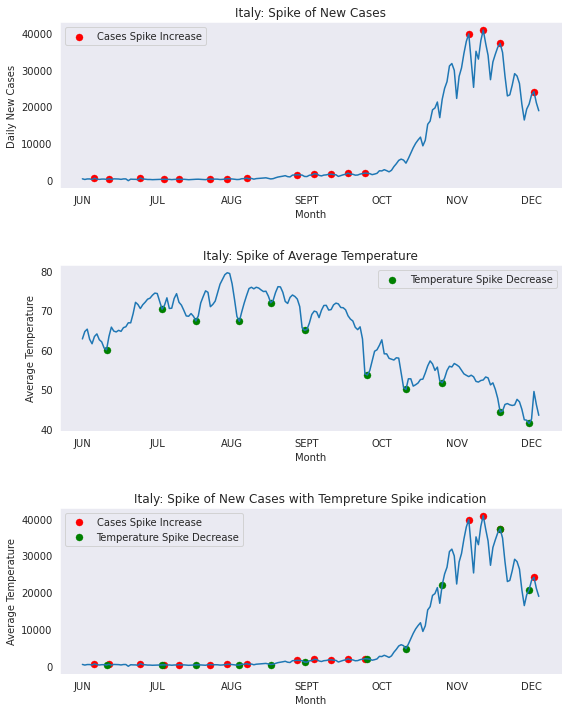

In [ ]:
compare_cases_to_temperature(Italy_df, Italy_weather, 'Italy')

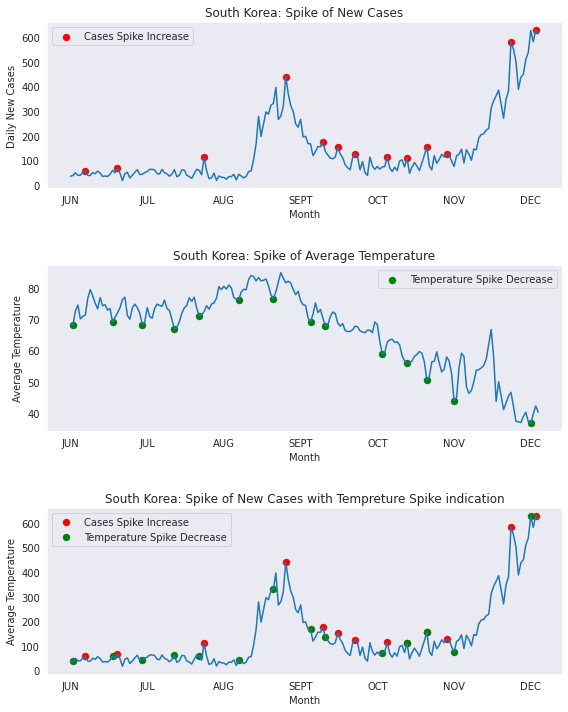

In [ ]:
compare_cases_to_temperature(SouthKorea_df, SouthKorea_weather, 'South Korea')

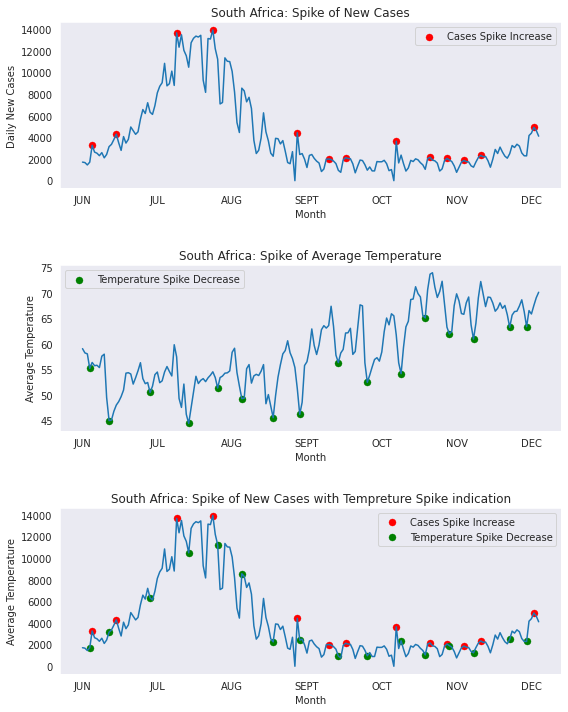

In [ ]:
compare_cases_to_temperature(SouthAfrica_df, SouthAfrica_weather, 'South Africa')

Now we will be calculating the covariance between the temperature and new cases in each of the above countries. 

In [ ]:
Italy_cov = pearsonr(Italy_df["newConfirmed"],Italy_weather["TAVG"])[0]
Italy_cov

-0.7644931209116416

In [ ]:
SouthAfrica_cov = pearsonr(SouthAfrica_df["newConfirmed"],SouthAfrica_weather["TAVG"])[0]
SouthAfrica_cov

-0.5098457331938366

In [ ]:
SouthKorea_cov = pearsonr(SouthKorea_df["newConfirmed"],SouthKorea_weather["TAVG"])[0]
SouthKorea_cov

-0.4921102106999024

As seen by the above findings, for each of the countries there is a large negative correlation between temperature and new cases of COVID-19. The strength of association is large because the values are between the range of -0.5 and -1.0. 

It does seem that as temperatures increase, the number of cases decreases.

## Why did we choose these countries?

We wanted a range of varying climates, we also wanted to select countries that had varying responses to the COVID-19 pandemic. For instance, South Korea has had the reputation as one of the best responses and Italy was known as one of the initial hot spots. 

## Why did we choose this date range?


We wanted to choose a start date that was after the inital confusion when the pandemic began. At the start of it all getting a test was very difficult in most countries. Because of this we suspected that data to be innacurate. This lead us to choose the start in the summer as at that point test were more easily available.